In [15]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
지오코딩 검증 (최소 컬럼 + URL)
- 출력: id, title, url, json_locations, csv_location
- csv_location = CSV의 loc + fac (있는 전부)
- url = CSV의 url(우선) 없으면 JSON url(있으면)
"""

import os, re, json, glob
import pandas as pd
from typing import Any, Dict, List, Optional, Tuple

# ===== 경로 =====
ANSWER_CSV = '/home/ds4_sia_nolb/#FINAL_POLARIS/08_performance_evaluation/geocoding_performance_data/final_preprocessing.dprk_loc_fac_sample12.csv'
GEOCODE_DIR = '/home/ds4_sia_nolb/#FINAL_POLARIS/06_Geo_coding/combined_data_by_year_polygon_mapping'
OUTPUT_CSV = '/home/ds4_sia_nolb/#FINAL_POLARIS/08_performance_evaluation/geocoding_performance_data/geocoding_eval_min_compare.csv'

# (업로드 경로로 테스트하려면 아래 주석 해제)
# ANSWER_CSV = '/mnt/data/final_preprocessing.dprk_loc_fac_sample30.csv'
# GEOCODE_DIR = '/mnt/data/combined_data_by_year_polygon_mapping'
# OUTPUT_CSV = '/mnt/data/geocoding_eval_min_compare.csv'

# ===== 키 후보 =====
ID_KEYS = ['id', 'id_', 'uuid', 'doc_id', 'docId', 'document_id', 'meta_id', 'item_id']
CSV_URL_KEYS = ['url', 'link', 'source_url', 'source', 'article_url']
JSON_URL_KEYS = ['url']  # 필요 시 확장 가능

# ===== 유틸 =====
def find_id_col(df: pd.DataFrame) -> str:
    for c in df.columns:
        if c in ID_KEYS:
            return c
    lower = {c.lower(): c for c in df.columns}
    for k in ID_KEYS:
        if k.lower() in lower:
            return lower[k.lower()]
    raise ValueError(f"id 컬럼을 찾지 못했습니다. 후보: {ID_KEYS}")

def pick_loc_fac_columns(df: pd.DataFrame) -> Tuple[List[str], List[str]]:
    """우선 정확히 'loc','fac' 사용. 없으면 유사 컬럼 자동 탐색."""
    cols = list(df.columns)
    # 정확 매칭 우선
    loc_cols = [c for c in cols if c == 'loc']
    fac_cols = [c for c in cols if c == 'fac']
    if loc_cols or fac_cols:
        return loc_cols, fac_cols

    # 없으면 패턴으로 탐색
    loc_pat = re.compile(r'(?:^|_)loc(?:$|_)|location|place', re.IGNORECASE)
    fac_pat = re.compile(r'(?:^|_)fac(?:$|_)|facility', re.IGNORECASE)
    loc_cols = [c for c in cols if loc_pat.search(c)]
    fac_cols = [c for c in cols if fac_pat.search(c)]
    fac_cols = [c for c in fac_cols if c not in loc_cols]  # 중복 제거

    return loc_cols, fac_cols

def nonempty_str(x: Any) -> Optional[str]:
    s = str(x) if x is not None else ""
    s = s.strip()
    return s if s else None

def first_nonempty_from_row(row: pd.Series, keys: List[str]) -> Optional[str]:
    for k in keys:
        if k in row and nonempty_str(row[k]):
            return str(row[k]).strip()
    return None

def load_json_records(path: str) -> List[Dict[str, Any]]:
    with open(path, 'r', encoding='utf-8') as f:
        obj = json.load(f)
    if isinstance(obj, list):
        return obj
    if isinstance(obj, dict):
        for k in ['records','data','items','docs','rows']:
            if k in obj and isinstance(obj[k], list):
                return obj[k]
        return [obj]
    return []

def extract_json_locations(rec: Dict[str, Any]) -> List[str]:
    """좌표 있는 name 우선, 없으면 'locations' 문자열 리스트 사용."""
    names: List[str] = []
    arr = rec.get('locations_with_coordinates') or []
    if isinstance(arr, list):
        for item in arr:
            if isinstance(item, dict) and nonempty_str(item.get('name')) and item.get('coordinates') is not None:
                names.append(str(item['name']).strip())
    if not names:
        locs = rec.get('locations')
        if isinstance(locs, list):
            names.extend([str(x).strip() for x in locs if nonempty_str(x)])
    return names

def extract_json_title(rec: Dict[str, Any]) -> str:
    if nonempty_str(rec.get('title')):
        return str(rec['title']).strip()
    meta = rec.get('metadata')
    if isinstance(meta, dict) and nonempty_str(meta.get('title')):
        return str(meta['title']).strip()
    return ""

def extract_json_url(rec: Dict[str, Any]) -> Optional[str]:
    # 1) 최상위 키
    for k in JSON_URL_KEYS:
        if nonempty_str(rec.get(k)):
            return str(rec[k]).strip()
    # 2) metadata 안쪽
    meta = rec.get('metadata')
    if isinstance(meta, dict):
        for k in JSON_URL_KEYS:
            if nonempty_str(meta.get(k)):
                return str(meta[k]).strip()
    return None

def build_index_all_years(folder: str) -> Dict[str, Dict[str, Any]]:
    """
    id -> {
      'names': set([...]),
      'title': sample_title,
      'urls': set([...])   # 여러 JSON에 있을 수 있으므로 집합으로 보관
    }
    """
    index: Dict[str, Dict[str, Any]] = {}
    for fp in sorted(glob.glob(os.path.join(folder, '*.json'))):
        for rec in load_json_records(fp):
            if not isinstance(rec, dict):
                continue
            rid = rec.get('id_')
            if not rid:
                for k in ID_KEYS:
                    if nonempty_str(rec.get(k)):
                        rid = str(rec[k]).strip()
                        break
            if not rid:
                continue
            rid = str(rid)

            bucket = index.setdefault(rid, {'names': set(), 'title': '', 'urls': set()})

            # 위치명
            for name in extract_json_locations(rec):
                bucket['names'].add(name)

            # 제목(비어있을 때만 보완)
            if not bucket['title']:
                t = extract_json_title(rec)
                if t:
                    bucket['title'] = t

            # URL 수집
            u = extract_json_url(rec)
            if u:
                bucket['urls'].add(u)

    return index

# ===== 메인 =====
def main():
    # 1) CSV 로드 & id/loc/fac 컬럼 파악
    df = pd.read_csv(ANSWER_CSV, dtype=str, keep_default_na=False)
    id_col = find_id_col(df)
    loc_cols, fac_cols = pick_loc_fac_columns(df)
    if not (loc_cols or fac_cols):
        raise ValueError("CSV에서 loc/fac 관련 컬럼을 찾지 못했습니다. (정확히 'loc','fac' 또는 location/facility 계열)")

    # 2) 모든 연도 JSON 인덱스
    geo_index = build_index_all_years(GEOCODE_DIR)

    # 3) 결과 생성
    out_rows = []
    for _, row in df.iterrows():
        rid = nonempty_str(row.get(id_col))
        if not rid:
            continue

        # title: CSV 우선, 없으면 JSON 보완
        title = nonempty_str(row.get('title'))
        if not title and rid in geo_index:
            title = geo_index[rid].get('title') or ""

        # url: CSV 우선, 없으면 JSON 보완(여러 개면 사전순 첫 번째)
        url_csv = first_nonempty_from_row(row, CSV_URL_KEYS)
        if url_csv:
            url = url_csv
        else:
            urls = []
            if rid in geo_index:
                urls = sorted(list(geo_index[rid].get('urls', set())))
            url = urls[0] if urls else ""

        # csv_location: loc + fac 전부 합치기 (비어있는 값 제외, 중복 제거, 원래 컬럼 순서 유지)
        pieces: List[str] = []
        for c in loc_cols + fac_cols:
            val = nonempty_str(row.get(c))
            if val:
                pieces.append(val)
        seen = set()
        merged = []
        for p in pieces:
            if p not in seen:
                seen.add(p)
                merged.append(p)
        csv_location = " | ".join(merged)

        # json_locations
        names = []
        if rid in geo_index:
            names = sorted(list(geo_index[rid].get('names', set())))
        json_locations = " | ".join(names)

        out_rows.append({
            'id': rid,
            'title': title or "",
            'url': url or "",
            'json_locations': json_locations,
            'csv_location': csv_location
        })

    out_df = pd.DataFrame(out_rows)
    os.makedirs(os.path.dirname(OUTPUT_CSV), exist_ok=True)
    out_df.to_csv(OUTPUT_CSV, index=False, encoding='utf-8-sig')
    print(f"저장 완료: {OUTPUT_CSV}  (행수: {len(out_df)})")

if __name__ == "__main__":
    main()


저장 완료: /home/ds4_sia_nolb/#FINAL_POLARIS/08_performance_evaluation/geocoding_performance_data/geocoding_eval_min_compare.csv  (행수: 11)


[OK] Loaded: (11, 5)


,id,title,url,json_locations,csv_location
0,8445625d-8cac-40b4-a7ec-08407207460c,"북한, 새해 첫날 '0시 불꽃놀이' 오후 9시로 연기",https://www.yna.co.kr/view/AKR20160101003500014,김일성광장 | 주변구역 | 평양 | 평양직할시,"김일성광장, 평양"
1,6557a166-f876-4d29-84c2-505c413df34d,마을·논밭 사라지고 철길도 뚝…北수해 전후 사진 비교,https://www.yna.co.kr/view/AKR20240801095700504,만포시 | 신의주 | 신의주시 | 자강도 | 평안북도 | 평양,"위화도, 신의주, 평안북도, 자강도, 만포시, 신의주시"
2,6176cfe1-78bf-419b-b5b2-3fac526e5483,"北 김정은, 예년보다 늦은 낮 12시30분 신년사 발표(종합)",https://www.yna.co.kr/view/AKR20160101022100014,평양시,평양시
3,6c6f7043-54ac-43a7-9b24-3bb7e8ab835c,"북한 \""어제 극초음속 중장거리 탄도미사일 발사 성공\",https://www.yna.co.kr/view/MYH20250107002700641,평양 | 평양시,"평양, 평양시 | 발사장"
4,2311bfb2-2d3e-4142-84d0-7fd5ce2d9f5a,"北, 구축함 진수사고 연일 책임자 처벌…군수공업부 부부장 구속",https://www.yna.co.kr/view/AKR20250526004300504,청진,청진 | 청진조선소


[OK] per-id computed: (11, 17)


,id,title,n_truth(csv_location),n_pred(json_locations),TP,FP,FN,precision,recall,f1,truth_items,pred_items,TP_items,FP_items,FN_items,truth_items_raw,pred_items_raw
0,8445625d-8cac-40b4-a7ec-08407207460c,"북한, 새해 첫날 '0시 불꽃놀이' 오후 9시로 연기",2,3,2,1,0,0.667,1.0,0.800,김일성광장 ; 평양,김일성광장 ; 평양 ; 평양직할,김일성광장 ; 평양,평양직할,,김일성광장 ; 평양,김일성광장 ; 주변구역 ; 평양 ; 평양직할시
1,6557a166-f876-4d29-84c2-505c413df34d,마을·논밭 사라지고 철길도 뚝…北수해 전후 사진 비교,5,5,4,1,1,0.800,0.8,0.800,만포 ; 신의주 ; 위화 ; 자강 ; 평안북,만포 ; 신의주 ; 자강 ; 평안북 ; 평양,만포 ; 신의주 ; 자강 ; 평안북,평양,위화,위화도 ; 신의주 ; 평안북도 ; 자강도 ; 만포시 ; 신의주시,만포시 ; 신의주 ; 신의주시 ; 자강도 ; 평안북도 ; 평양
2,6176cfe1-78bf-419b-b5b2-3fac526e5483,"北 김정은, 예년보다 늦은 낮 12시30분 신년사 발표(종합)",1,1,1,0,0,1.000,1.0,1.000,평양,평양,평양,,,평양시,평양시
3,6c6f7043-54ac-43a7-9b24-3bb7e8ab835c,"북한 \""어제 극초음속 중장거리 탄도미사일 발사 성공\",2,1,1,0,1,1.000,0.5,0.667,발사장 ; 평양,평양,평양,,발사장,평양 ; 평양시 ; 발사장,평양 ; 평양시
4,2311bfb2-2d3e-4142-84d0-7fd5ce2d9f5a,"北, 구축함 진수사고 연일 책임자 처벌…군수공업부 부부장 구속",2,1,1,0,1,1.000,0.5,0.667,청진 ; 청진조선소,청진,청진,,청진조선소,청진 ; 청진조선소,청진


[SUMMARY]


,macro_precision,macro_recall,macro_f1,micro_precision,micro_recall,micro_f1,sum_TP,sum_FP,sum_FN,sum_truth_items,sum_pred_items
0,0.724,0.602,0.629,0.645,0.526,0.58,20,11,18,38,31


[Saved] /home/ds4_sia_nolb/#FINAL_POLARIS/08_performance_evaluation/geocoding_performance_data/json_vs_csv_per_id_exact.csv
[Saved] /home/ds4_sia_nolb/#FINAL_POLARIS/08_performance_evaluation/geocoding_performance_data/json_vs_csv_summary_exact.csv


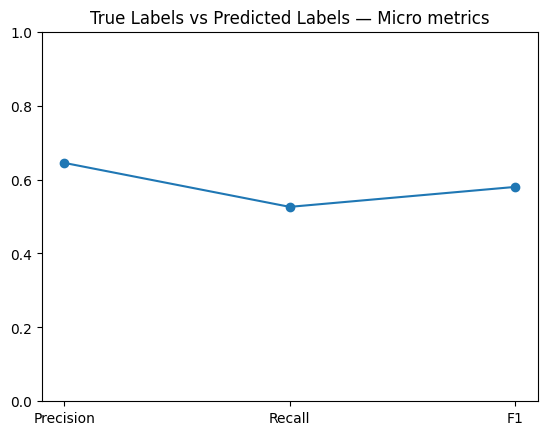

,id,title,precision,recall,f1,TP_items,FP_items,FN_items,truth_items,pred_items
6,ede3af55-0a30-4c82-8b71-f78aefa2d4e0,"에이브럼스 \""北 비핵화 신뢰구축 계속 지원할 것",0.333,0.333,0.333,공동경비구역,개성공업지 ; 판문,군사분계선 ; 판문점,공동경비구역 ; 군사분계선 ; 판문점,개성공업지 ; 공동경비구역 ; 판문
7,034c64cc-56cf-4941-9a82-3c536a87640e,북한 영변 핵시설 가동 '활발'…플루토늄·HEU 생산 계속,0.667,0.222,0.333,개성 ; 평안북,라진,개성공업지구 ; 남북연락사무소 ; 방사화학실험실 ; 영변 ; 우라늄농축시설 ; 종합...,개성 ; 개성공업지구 ; 남북연락사무소 ; 방사화학실험실 ; 영변 ; 우라늄농축시설...,개성 ; 라진 ; 평안북
5,1c24d4eb-e950-4d4e-9440-83d648d11453,"北 김정은, 금수산궁전 참배로 새해 첫 활동",0.333,0.500,0.400,평양,금수산태양궁전 ; 평양직할,금수산궁전,금수산궁전 ; 평양,금수산태양궁전 ; 평양 ; 평양직할
10,d1aced63-4357-4c04-b5ca-a9764d728d54,"북한 8차 당대회 앞두고 '80일전투' 결산…\""충천한 기세 과시\",0.500,0.600,0.545,강원 ; 삼지연 ; 황해북,백두산 ; 사리원 ; 원산,중앙위원회 ; 함경,강원 ; 삼지연 ; 중앙위원회 ; 함경 ; 황해북,강원 ; 백두산 ; 사리원 ; 삼지연 ; 원산 ; 황해북
8,a222527c-bd5d-4dd2-81ae-e5cc6bd6c099,"北, 예성강 유역서 구석기시대 유적 발굴",0.667,0.500,0.571,김일성종합대학 ; 황해북,평양직할,사정 ; 신계,김일성종합대학 ; 사정 ; 신계 ; 황해북,김일성종합대학 ; 평양직할 ; 황해북
3,6c6f7043-54ac-43a7-9b24-3bb7e8ab835c,"북한 \""어제 극초음속 중장거리 탄도미사일 발사 성공\",1.000,0.500,0.667,평양,,발사장,발사장 ; 평양,평양
4,2311bfb2-2d3e-4142-84d0-7fd5ce2d9f5a,"北, 구축함 진수사고 연일 책임자 처벌…군수공업부 부부장 구속",1.000,0.500,0.667,청진,,청진조선소,청진 ; 청진조선소,청진
0,8445625d-8cac-40b4-a7ec-08407207460c,"북한, 새해 첫날 '0시 불꽃놀이' 오후 9시로 연기",0.667,1.000,0.800,김일성광장 ; 평양,평양직할,,김일성광장 ; 평양,김일성광장 ; 평양 ; 평양직할
9,af438b04-0a34-4eed-bf6f-d621123e7786,"WSJ \""'北핵무기 12기 추가생산 가능성' 보도, 부정확\""…내용정정",1.000,0.667,0.800,강원 ; 원산,,호도반,강원 ; 원산 ; 호도반,강원 ; 원산
1,6557a166-f876-4d29-84c2-505c413df34d,마을·논밭 사라지고 철길도 뚝…北수해 전후 사진 비교,0.800,0.800,0.800,만포 ; 신의주 ; 자강 ; 평안북,평양,위화,만포 ; 신의주 ; 위화 ; 자강 ; 평안북,만포 ; 신의주 ; 자강 ; 평안북 ; 평양


In [17]:
# %% [markdown]
# # JSON vs CSV (정답) 위치 비교 평가 — 정규화 강화 버전
# - 입력: geocoding_eval_min_compare.csv (열: id, title, url, json_locations, csv_location)
# - 정답 = csv_location, 예측 = json_locations
# - 정확 일치 기반 집합 비교(per-ID + micro/macro 요약)
# - 깔끔한 표기를 위해 강한 정규화 적용(접미사/노이즈/동의어 등)

# %%
# === 경로 설정 ===
EVAL_CSV_PATH = '/home/ds4_sia_nolb/#FINAL_POLARIS/08_performance_evaluation/geocoding_performance_data/geocoding_eval_min_compare.csv'

# 출력 경로
OUT_PER_ID   = '/home/ds4_sia_nolb/#FINAL_POLARIS/08_performance_evaluation/geocoding_performance_data/json_vs_csv_per_id_exact.csv'
OUT_SUMMARY  = '/home/ds4_sia_nolb/#FINAL_POLARIS/08_performance_evaluation/geocoding_performance_data/json_vs_csv_summary_exact.csv'

# 정규화 옵션
NORMALIZE_ADMIN_SUFFIX = True     # 시/군/구/읍/면/동/리/도/특별시/광역시/자치시/특별자치시/특별자치도 제거
REMOVE_GUYOK            = False   # DPRK '구역' 제거 여부 (기본 False: 정보 손실 방지)
APPLY_SYNONYMS          = True    # 동의어 매핑 적용
DROP_NOISE_TOKENS       = True    # 주변/일대/부근/인근/지역/권역/시내/도심/해역/연안/상공 등 제거

# %%
import pandas as pd
import numpy as np
import re, unicodedata
from typing import List, Tuple, Optional
import matplotlib.pyplot as plt
from IPython.display import display

# --- 유틸 ---
def nonempty(s):
    if s is None:
        return None
    try:
        if isinstance(s, float) and np.isnan(s):
            return None
    except:
        pass
    s2 = str(s).strip()
    return s2 if s2 else None

def split_multi(s: Optional[str]) -> List[str]:
    """'|', ',', ';' 구분자 지원. 공백 정리 + 중복 제거(순서 유지)."""
    s2 = nonempty(s)
    if not s2:
        return []
    parts = [p.strip() for p in re.split(r"\s*\|\s*|\s*,\s*|\s*;\s*", s2) if p.strip()]
    seen, out = set(), []
    for p in parts:
        if p not in seen:
            seen.add(p)
            out.append(p)
    return out

# --- 정규화 리소스 ---
COUNTRY_NOISE = {
    "조선민주주의인민공화국","조선","공화국","북한","대한민국","한국"
}
NOISE_TOKENS = {
    "주변","주변구역","일대","부근","인근","지역","일원","권역","시내","도심","해역","연안","상공"
}

# 행정 접미사 정규식 구성
_admin_suffix = r"(특별시|광역시|자치시|특별자치시|특별자치도|도|시|군|구|읍|면|동|리"
if REMOVE_GUYOK:
    _admin_suffix += r"|구역"
_admin_suffix += r")$"
ADMIN_SUFFIX_RE = re.compile(_admin_suffix)

PARENS_RE = re.compile(r"[()\[\]{}<>「」『』“”‘’\"']+")
SEP_RE    = re.compile(r"[·•,.:;~\-_/\\|]+")
MULTI_WS  = re.compile(r"\s+")

# 동의어(표준형) — 필요 시 계속 추가하세요
SYNONYM_MAP_RAW = {
    # 도시/광역
    "평양직할시": "평양", "평양시": "평양",
    "개성시": "개성", "함흥시": "함흥", "청진시": "청진", "나선시": "나선",
    "신의주시": "신의주", "혜산시": "혜산", "사리원시": "사리원",
    "원산시": "원산", "남포시": "남포", "평성시": "평성", "해주시": "해주",
    "강계시": "강계",

    # 랜드마크/시설
    "김일성 광장": "김일성광장",
    "개성 공업 지구": "개성공업지구", "개성공단": "개성공업지구",
}
# 공백 제거 버전도 매핑
SYNONYM_MAP = dict(SYNONYM_MAP_RAW)
for k, v in list(SYNONYM_MAP_RAW.items()):
    SYNONYM_MAP[k.replace(" ", "")] = v
    SYNONYM_MAP[v.replace(" ", "")] = v

def normalize_name(s: str) -> str:
    """강화된 정규화 파이프라인."""
    if not s:
        return ""
    s = unicodedata.normalize("NFC", str(s))
    s = PARENS_RE.sub(" ", s)
    s = SEP_RE.sub(" ", s)
    s = MULTI_WS.sub(" ", s).strip()

    toks = [t for t in s.split() if t not in COUNTRY_NOISE]

    if NORMALIZE_ADMIN_SUFFIX:
        toks2 = []
        for t in toks:
            t2 = ADMIN_SUFFIX_RE.sub("", t).strip()
            if t2:
                toks2.append(t2)
        toks = toks2

    if DROP_NOISE_TOKENS:
        toks = [t for t in toks if t not in NOISE_TOKENS]

    # 공백 제거로 재조립(김일성 광장 → 김일성광장)
    s = "".join(toks)

    if APPLY_SYNONYMS and s in SYNONYM_MAP:
        s = SYNONYM_MAP[s]

    return s

def to_set(items: List[str]) -> set:
    """정규화 후 set으로 변환 (빈 문자열 제거)"""
    out = set()
    for x in items:
        nx = normalize_name(x)
        if nx:
            out.add(nx)
    return out

def prf_from_counts(tp: int, fp: int, fn: int):
    prec = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    rec  = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    f1   = (2*prec*rec/(prec+rec)) if (isinstance(prec, float) and isinstance(rec, float) and (prec==prec) and (rec==rec) and (prec+rec)>0) else np.nan
    return prec, rec, f1

def safe_mean(vals):
    arr = np.array([v for v in vals if v is not None and not pd.isna(v)], dtype=float)
    return float(arr.mean()) if len(arr)>0 else np.nan

# %%
# 1) CSV 로드
df = pd.read_csv(EVAL_CSV_PATH, dtype=str, keep_default_na=False)
need = {'id', 'json_locations', 'csv_location'}
missing = need - set(df.columns)
if missing:
    raise ValueError(f"필수 컬럼이 없습니다: {missing}")
print(f"[OK] Loaded: {df.shape}")
display(df.head())

# %%
# 2) per-ID 계산 (정답=csv_location, 예측=json_locations)
rows = []
sum_tp = sum_fp = sum_fn = 0

for _, r in df.iterrows():
    rid   = r['id']
    title = nonempty(r.get('title')) or ''
    truth_list_raw = split_multi(r.get('csv_location'))      # 정답(원문 목록)
    pred_list_raw  = split_multi(r.get('json_locations'))    # 예측(원문 목록)

    # 정규화 후 집합화
    truth_set = to_set(truth_list_raw)
    pred_set  = to_set(pred_list_raw)

    tp_items = sorted(list(truth_set & pred_set))
    fp_items = sorted(list(pred_set - truth_set))
    fn_items = sorted(list(truth_set - pred_set))

    tp = len(tp_items)
    fp = len(fp_items)
    fn = len(fn_items)

    prec, rec, f1 = prf_from_counts(tp, fp, fn)

    rows.append({
        'id': rid,
        'title': title,
        'n_truth(csv_location)': len(truth_set),
        'n_pred(json_locations)': len(pred_set),
        'TP': tp, 'FP': fp, 'FN': fn,
        'precision': None if pd.isna(prec) else round(prec, 3),
        'recall':    None if pd.isna(rec) else round(rec, 3),
        'f1':        None if pd.isna(f1) else round(f1, 3),
        # 정규화된 표기(깔끔)
        'truth_items': " ; ".join(sorted(list(truth_set))),
        'pred_items':  " ; ".join(sorted(list(pred_set))),
        'TP_items':    " ; ".join(tp_items),
        'FP_items':    " ; ".join(fp_items),
        'FN_items':    " ; ".join(fn_items),
        # 진단용(원문 그대로 보고 싶을 때)
        'truth_items_raw': " ; ".join(truth_list_raw),
        'pred_items_raw':  " ; ".join(pred_list_raw),
    })

    sum_tp += tp
    sum_fp += fp
    sum_fn += fn

per_id = pd.DataFrame(rows)
print(f"[OK] per-id computed: {per_id.shape}")
display(per_id.head())

# %%
# 3) 요약(macro/micro)
macro_p = safe_mean(per_id['precision'].tolist())
macro_r = safe_mean(per_id['recall'].tolist())
macro_f = safe_mean(per_id['f1'].tolist())

micro_p, micro_r, micro_f = prf_from_counts(sum_tp, sum_fp, sum_fn)

summary = pd.DataFrame([{
    'macro_precision': None if pd.isna(macro_p) else round(macro_p, 3),
    'macro_recall':    None if pd.isna(macro_r) else round(macro_r, 3),
    'macro_f1':        None if pd.isna(macro_f) else round(macro_f, 3),
    'micro_precision': None if pd.isna(micro_p) else round(micro_p, 3),
    'micro_recall':    None if pd.isna(micro_r) else round(micro_r, 3),
    'micro_f1':        None if pd.isna(micro_f) else round(micro_f, 3),
    'sum_TP': int(sum_tp), 'sum_FP': int(sum_fp), 'sum_FN': int(sum_fn),
    'sum_truth_items': int(per_id['n_truth(csv_location)'].sum()),
    'sum_pred_items':  int(per_id['n_pred(json_locations)'].sum()),
}])

print("[SUMMARY]")
display(summary)

# %%
# 4) 저장
per_id.to_csv(OUT_PER_ID, index=False, encoding='utf-8-sig')
summary.to_csv(OUT_SUMMARY, index=False, encoding='utf-8-sig')
print(f"[Saved] {OUT_PER_ID}")
print(f"[Saved] {OUT_SUMMARY}")

# %%
# 5) 간단 플롯: micro 지표 (한 그림 = 하나의 차트)
plt.figure()
plt.plot(['Precision','Recall','F1'],
         [summary.loc[0,'micro_precision'], summary.loc[0,'micro_recall'], summary.loc[0,'micro_f1']],
         marker='o')
plt.title('True Labels vs Predicted Labels — Micro metrics')
plt.ylim(0, 1)
plt.show()

# %%
# 6) 에러 점검용: F1 낮은 샘플 상위 20개
bad = per_id.sort_values(by=['f1'], ascending=True, na_position='last').head(20)
display(bad[['id','title','precision','recall','f1','TP_items','FP_items','FN_items','truth_items','pred_items']])
